# Modelos Lineales Generalizados (GML)

## Regresión Lineal Gaussiana

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
gdf = gpd.read_file(
    "https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg"
)
gdf.info()

In [4]:
gdf["y_log"] = np.log(gdf["cfr"] + 1)
var = ["area_municipio", "altitud", "temperatura", "humedad_relativa", "urbanizacion", "densidad"]

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])

X = sm.add_constant(X_scaled)
y = gdf["y_log"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     4.899
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           0.000166
Time:                        02:38:33   Log-Likelihood:                -33.475
No. Observations:                 125   AIC:                             80.95
Df Residuals:                     118   BIC:                             100.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3240      0.029     45.473      0.0

In [5]:
# Obtener las predicciones
y_pred = model.predict(X)
gdf["y_pred"] = y_pred

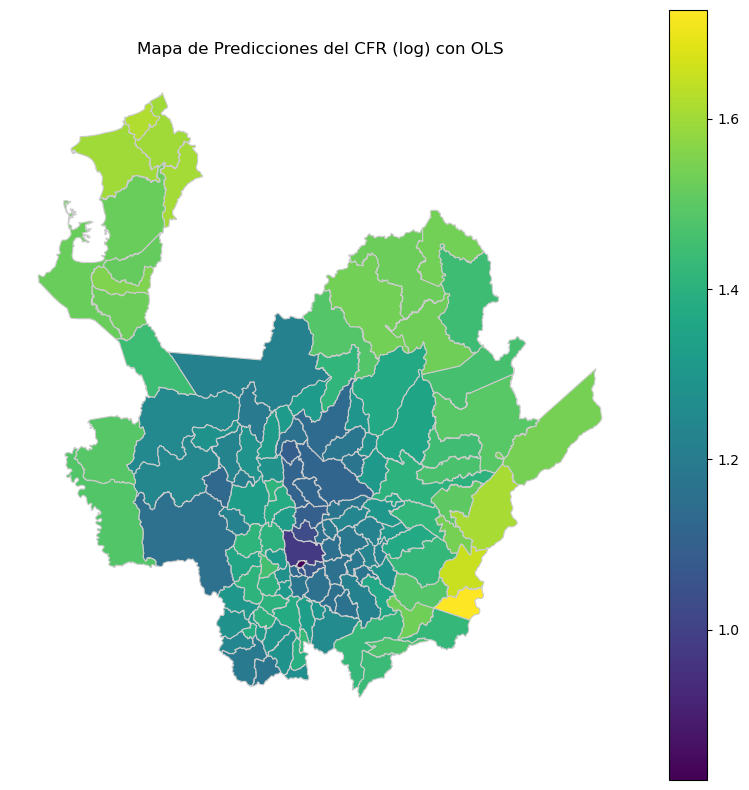

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="y_pred", cmap="viridis", legend=True, ax=ax, linewidth=0.8, edgecolor="0.8"
)
ax.set_title("Mapa de Predicciones del CFR (log) con OLS")
ax.set_axis_off()
plt.show()

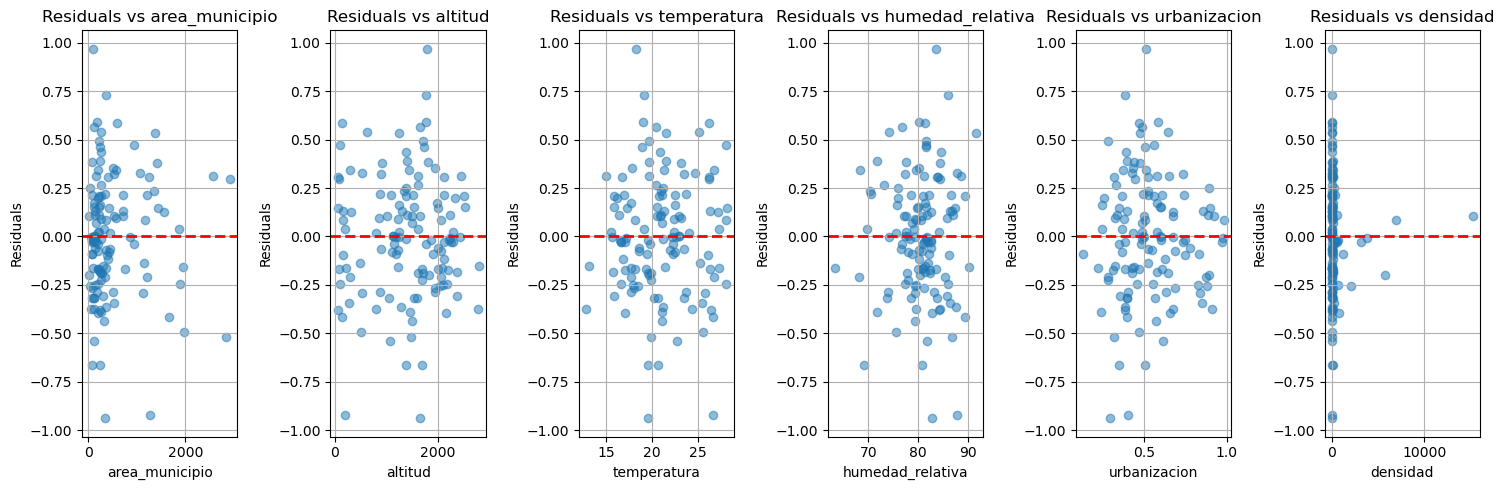

In [7]:
# Calculate the residuals
residuals = y - y_pred

# Create figure for residuals
plt.figure(figsize=(15, 5))

for i, variable in enumerate(var):
    plt.subplot(1, len(var), i + 1)
    plt.scatter(gdf[variable], residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--", lw=2)
    plt.title(f"Residuals vs {variable}")
    plt.xlabel(variable)
    plt.ylabel("Residuals")
    plt.grid(True)

plt.tight_layout()
plt.show()

#### Conclusiones

Aunque los residuos no muestran un patrón drásticamente incorrecto (como curvaturas o fanning claro), sí existen indicios de heterocedasticidad y posible dependencia espacial, especialmente:

En variables con fuerte concentración de valores (densidad y urbanizacion).

La posible influencia geográfica no explicada por OLS puede ser mejor capturada por modelos como SAR (estructura espacial global) o GWR (variabilidad espacial local).

## Regresión Logística

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

In [9]:
gdf["evento_cfr"] = np.where(gdf["cfr"] > 3, 1, 0)

var = ["area_municipio", "altitud", "temperatura", "humedad_relativa", "urbanizacion", "densidad"]
y = gdf["evento_cfr"]

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])
X = sm.add_constant(X_scaled)

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.573067
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             evento_cfr   No. Observations:                  125
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            6
Date:                Fri, 25 Jul 2025   Pseudo R-squ.:                  0.1701
Time:                        02:52:06   Log-Likelihood:                -71.633
converged:                       True   LL-Null:                       -86.319
Covariance Type:            nonrobust   LLR p-value:                 5.174e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9660      0.722     -1.337      0.181      -2.382       0.450
x1            -0.1266      0

```text
Optimization terminated successfully.
         Current function value: 0.573067
         Iterations 10
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             evento_cfr   No. Observations:                  125
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            6
Date:                Wed, 23 Jul 2025   Pseudo R-squ.:                  0.1701
Time:                        02:29:03   Log-Likelihood:                -71.633
converged:                       True   LL-Null:                       -86.319
Covariance Type:            nonrobust   LLR p-value:                 5.174e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9660      0.722     -1.337      0.181      -2.382       0.450
x1            -0.1266      0.247     -0.513      0.608      -0.610       0.357
x2            -0.8958      1.522     -0.589      0.556      -3.879       2.087
x3            -0.1861      1.506     -0.124      0.902      -3.138       2.766
x4            -0.2994      0.237     -1.266      0.206      -0.763       0.164
x5            -0.0707      0.252     -0.280      0.779      -0.565       0.423
x6            -4.6452      3.622     -1.283      0.200     -11.744       2.454
==============================================================================
```

**Conclusiones**

En resumen, aunque su modelo Logit es estadísticamente significativo en general, las variables independientes incluidas no demuestran un poder predictivo individual significativo sobre la probabilidad de evento_cfr. Es crucial investigar las posibles razones de esta discrepancia para mejorar la especificación de su modelo.



In [10]:
y_prob = model.predict(X)

gdf["probability_eventCFR"] = y_prob

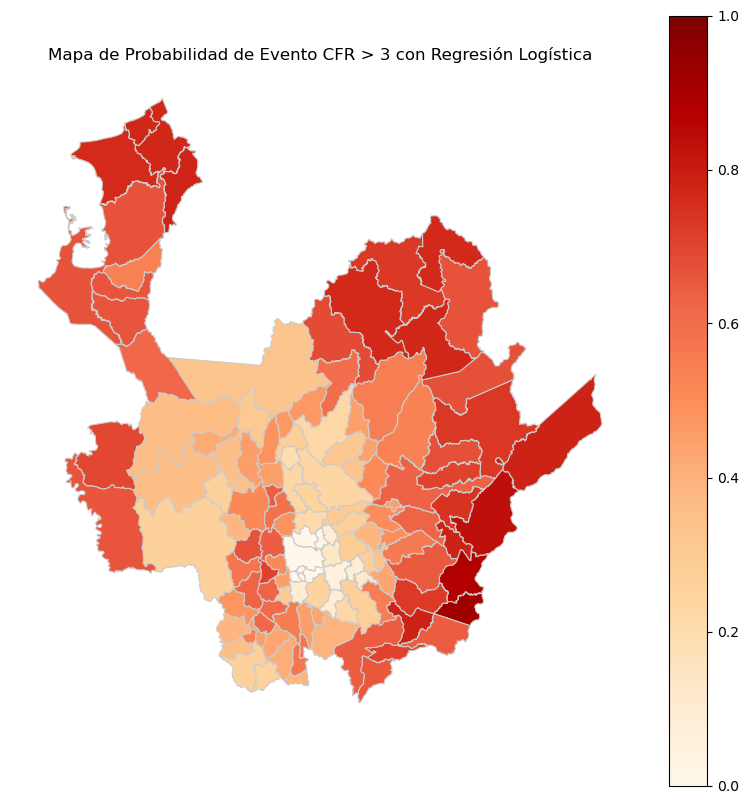

In [11]:
# Plot map with probabilities predicted by the logistic regression
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="probability_eventCFR",
    cmap="OrRd",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
    vmin=0,
    vmax=1,
)
ax.set_title("Mapa de Probabilidad de Evento CFR > 3 con Regresión Logística")
ax.set_axis_off()
plt.show()

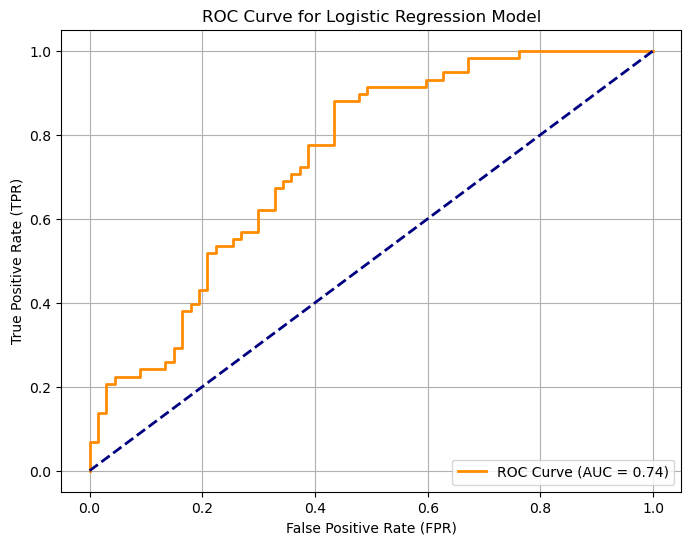

In [12]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_prob)
auc = roc_auc_score(y, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Logistic Regression Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

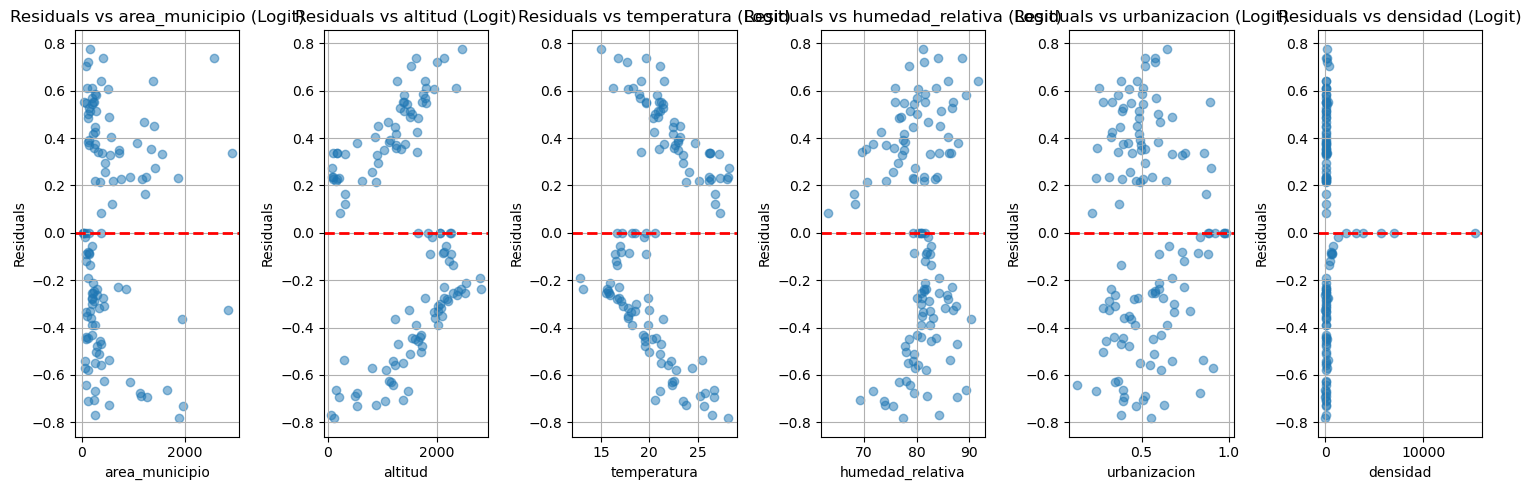

In [13]:
# Calculate the residuals for the logistic regression model
residuals_logit = y - y_prob
# Create figure for residuals of logistic regression
plt.figure(figsize=(15, 5))
for i, variable in enumerate(var):
    plt.subplot(1, len(var), i + 1)
    plt.scatter(gdf[variable], residuals_logit, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--", lw=2)
    plt.title(f"Residuals vs {variable} (Logit)")
    plt.xlabel(variable)
    plt.ylabel("Residuals")
    plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusiones**  

En general, la mayoría de los gráficos de residuos para el modelo Logit muestran una dispersión aleatoria razonable, lo cual es un indicio de que los supuestos generales del modelo están siendo cumplidos.

Sin embargo, el gráfico de Residuos vs temperatura sugiere que la relación entre temperatura y la probabilidad de evento_cfr podría no ser lineal. Considerar la inclusión de un término cuadrático para temperatura (temperatura2) o explorar una transformación diferente de temperatura podría mejorar el ajuste del modelo.

El patrón en Residuos vs densidad es más peculiar y podría estar relacionado con la naturaleza de la variable densidad o cómo se comporta en relación con la variable binaria evento_cfr. No necesariamente indica un problema con el modelo, sino una característica de los datos o de cómo el modelo hace las predicciones para esa variable.

Estos gráficos visuales complementan los resultados numéricos. Aunque el modelo Logit en su conjunto era significativo (según el LLR p-value), la falta de significancia individual de las variables y el patrón observado con temperatura sugieren que hay margen para mejorar la especificación del modelo para capturar mejor las relaciones subyacentes en sus datos.

## Regresión de Poisson

In [14]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [15]:
y = gdf["cfr"]
var = ["altitud", "temperatura", "humedad_relativa", "urbanizacion", "densidad"]  
# No area_municipio for GLM
exposure = np.log(gdf["area_municipio"])

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])
X = sm.add_constant(X_scaled)
poisson_model_offset = GLM(y, X, family=families.Poisson(), offset=exposure).fit()

print(poisson_model_offset.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cfr   No. Observations:                  125
Model:                            GLM   Df Residuals:                      119
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -328.61
Date:                Fri, 25 Jul 2025   Deviance:                       296.14
Time:                        02:59:55   Pearson chi2:                     448.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5450
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9109      0.053    -92.880      0.0

```text
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    cfr   No. Observations:                  125
Model:                            GLM   Df Residuals:                      119
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -328.61
Date:                Wed, 23 Jul 2025   Deviance:                       296.14
Time:                        02:42:08   Pearson chi2:                     448.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5450
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9109      0.053    -92.880      0.000      -5.015      -4.807
x1             1.2899      0.408      3.162      0.002       0.490       2.089
x2             0.8924      0.401      2.226      0.026       0.106       1.678
x3            -0.2209      0.049     -4.546      0.000      -0.316      -0.126
x4            -0.0076      0.061     -0.124      0.902      -0.128       0.113
x5             0.1025      0.084      1.218      0.223      -0.062       0.267
==============================================================================
```

**Conclusiones**  
 

Modelo Apropiado para Conteo: La elección de un modelo GLM con familia Poisson es adecuada si cfr es una variable de conteo.

Buen Poder Explicativo: El Pseudo R-cuadrado de 0.5450 es mucho más alto que los de los modelos anteriores, lo que indica que este modelo GLM tiene un poder explicativo significativamente mayor para cfr.

Variables Significativas: Las variables x1, x2 y x3 muestran un efecto estadísticamente significativo en la predicción del conteo esperado de cfr.

x1 y x2 tienen efecto positivo y significativo sobre el CFR.

x3 tiene efecto negativo fuerte y significativo.

x4 y x5 no contribuyen significativamente (pueden eliminarse o transformarse).

Variables No Significativas: x4 y x5 no parecen tener un efecto significativo.

Presencia de Sobredispersión: La alta Pearson chi2 en relación con los grados de libertad sugiere que el modelo Poisson podría estar subestimando la variabilidad real en los datos. Esto es un punto crítico a abordar.

In [18]:
# Get predictions
y_pred_offset = poisson_model_offset.predict(X)
gdf["predicted_cfr_offset"] = y_pred_offset

# Calculate residuals
gdf["difference_cfr_offset"] = gdf["cfr"] - gdf["predicted_cfr_offset"]

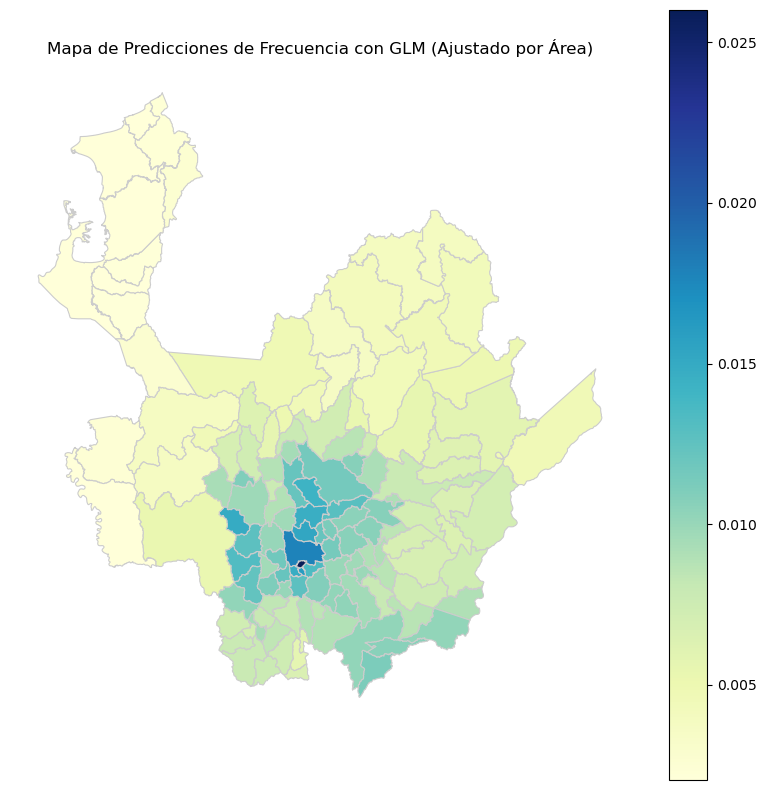

In [19]:
# Plotting the predictions with offset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="predicted_cfr_offset",
    cmap="YlGnBu",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
)
ax.set_title("Mapa de Predicciones de Frecuencia con GLM (Ajustado por Área)")
ax.set_axis_off()
plt.show()

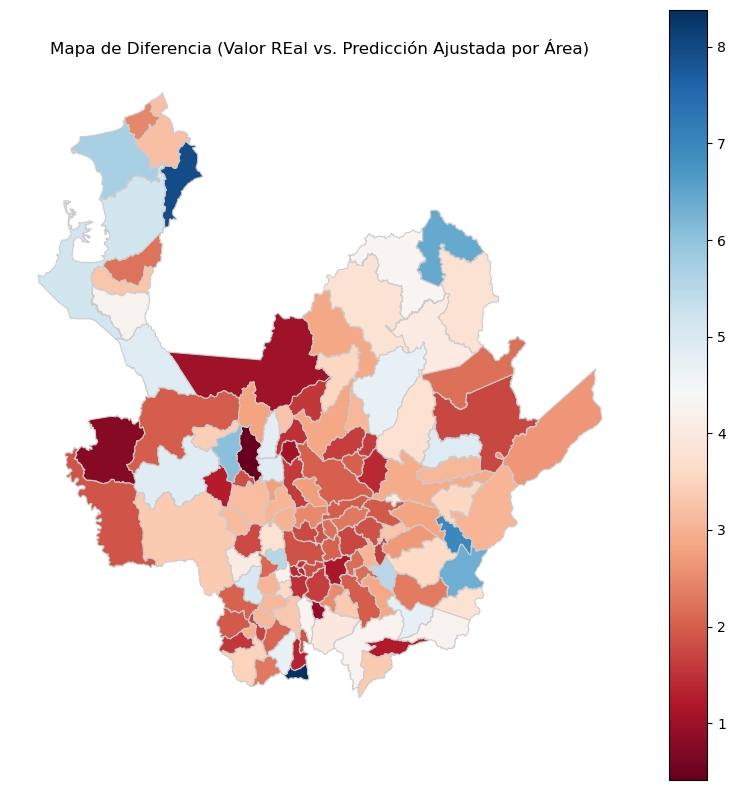

In [20]:
# Plotting the residuals for GLM with offset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="difference_cfr_offset",
    cmap="RdBu",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
)
ax.set_title("Mapa de Diferencia (Valor REal vs. Predicción Ajustada por Área)")
ax.set_axis_off()
plt.show()

## Regresión Binomial Negativa

In [21]:
y = gdf["cfr"]
var = ["altitud", "temperatura", "humedad_relativa", "urbanizacion", "densidad"]  
# No area_municipio for GLM
exposure = np.log(gdf["area_municipio"])

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])
X = sm.add_constant(X_scaled)

negative_binomial_model_offset = GLM(y, X, family=families.NegativeBinomial()).fit()
print(negative_binomial_model_offset.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cfr   No. Observations:                  125
Model:                            GLM   Df Residuals:                      119
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.07
Date:                Fri, 25 Jul 2025   Deviance:                       17.170
Time:                        03:05:55   Pearson chi2:                     17.7
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03499
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0758      0.104     10.353      0.0

/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


```text
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    cfr   No. Observations:                  125
Model:                            GLM   Df Residuals:                      119
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.07
Date:                Wed, 23 Jul 2025   Deviance:                       17.170
Time:                        02:53:53   Pearson chi2:                     17.7
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03499
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0758      0.104     10.353      0.000       0.872       1.279
x1            -0.4077      0.744     -0.548      0.584      -1.867       1.051
x2            -0.2362      0.751     -0.315      0.753      -1.707       1.235
x3            -0.0571      0.115     -0.495      0.620      -0.283       0.169
x4            -0.0290      0.115     -0.252      0.801      -0.254       0.196
x5            -0.0710      0.130     -0.545      0.586      -0.326       0.184
==============================================================================
```

**Conclusiones**  
La principal conclusión de este modelo de Regresión Binomial Negativa es su bajo poder predictivo (Pseudo R-cuadrado ~0.03). Esto significa que las variables altitud, temperatura, humedad_relativa y densidad explican muy poco de la variabilidad en la Tasa de Letalidad cuando se asume una distribución Binomial Negativa.

A diferencia del modelo de Poisson anterior, ninguna de las variables predictoras  resultó ser estadísticamente significativa. 

Aunque el modelo de Regresión Binomial Negativa puede ser teóricamente más apropiado si hay sobredispersion, los resultados prácticos de este ajuste sugieren que es un modelo mucho menos explicativo y menos útil para identificar los factores que influyen en la Tasa de Letalidad de COVID-19

In [47]:
# Get predictions for Negative Binomial model with offset
y_pred_nb_offset = negative_binomial_model_offset.predict(X)

gdf["predicted_cfr_nb_offset"] = y_pred_nb_offset

# Calculate residuals for Negative Binomial model with offset
gdf["difference_cfr_nb_offset"] = gdf["cfr"] - gdf["predicted_cfr_nb_offset"]

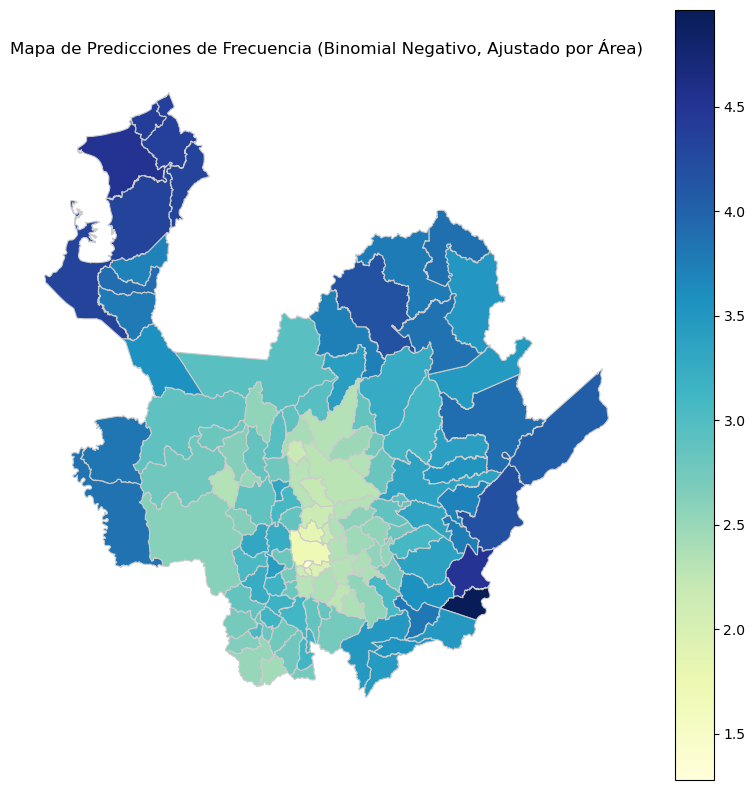

In [48]:
# Plotting the predictions for Negative Binomial model with offset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="predicted_cfr_nb_offset",
    cmap="YlGnBu",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
)
ax.set_title(
    "Mapa de Predicciones de Frecuencia (Binomial Negativo, Ajustado por Área)"
)
ax.set_axis_off()
plt.show()

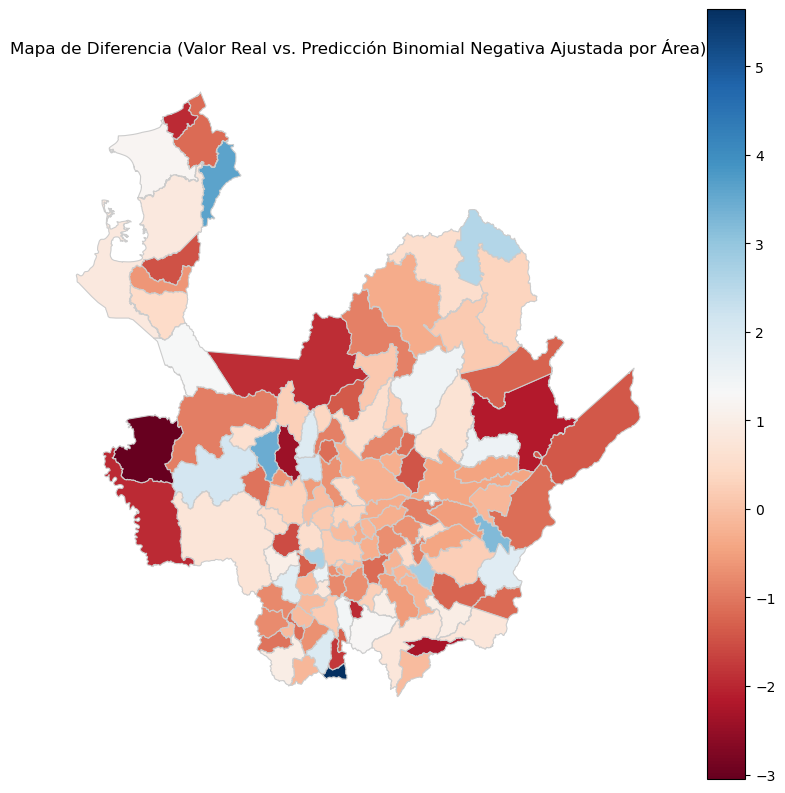

In [49]:
# Plotting the residuals for Negative Binomial model with offset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="difference_cfr_nb_offset",
    cmap="RdBu",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
)
ax.set_title(
    "Mapa de Diferencia (Valor Real vs. Predicción Binomial Negativa Ajustada por Área)"
)
ax.set_axis_off()
plt.show()

## Modelo de Ceros Inflados de Poisson

In [50]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson

In [51]:
y = gdf["cfr"]
var = ["altitud", "temperatura", "humedad_relativa", "urbanizacion", "densidad"]  
# No area_municipio for ZIP
exposure = np.log(gdf["area_municipio"])

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])

X = sm.add_constant(X_scaled)
zip_model_offset = ZeroInflatedPoisson(y, X, exposure=exposure).fit()

print(zip_model_offset.summary())

         Current function value: 1.744450
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                     cfr   No. Observations:                  125
Model:             ZeroInflatedPoisson   Df Residuals:                      119
Method:                            MLE   Df Model:                            5
Date:                 Wed, 23 Jul 2025   Pseudo R-squ.:                 0.01311
Time:                         04:57:48   Log-Likelihood:                -218.06
converged:                       False   LL-Null:                       -220.95
Covariance Type:             nonrobust   LLR p-value:                    0.3266
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -18.0946    759.870     -0.024      0.981   -1

/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


```text
Optimization terminated successfully.
         Current function value: 1.744501
         Iterations: 29
         Function evaluations: 32
         Gradient evaluations: 32
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                     cfr   No. Observations:                  125
Model:             ZeroInflatedPoisson   Df Residuals:                      120
Method:                            MLE   Df Model:                            4
Date:                 Wed, 25 Jun 2025   Pseudo R-squ.:                 0.01305
Time:                         02:06:25   Log-Likelihood:                -218.06
converged:                        True   LL-Null:                       -220.95
Covariance Type:             nonrobust   LLR p-value:                    0.2172
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -16.6002    359.947     -0.046      0.963    -722.084     688.884
const            -0.6533      0.053    -12.359      0.000      -0.757      -0.550
x1               -0.1423      0.364     -0.391      0.696      -0.856       0.571
x2               -0.0672      0.367     -0.183      0.855      -0.787       0.653
x3               -0.0783      0.053     -1.465      0.143      -0.183       0.026
x4               -0.0299      0.077     -0.389      0.697      -0.181       0.121
=================================================================================
```

**Conclusiones**

Este modelo de Regresión de Ceros Inflados de Poisson no es adecuado para explicar la Tasa de Letalidad por COVID-19 en este conjunto de datos. Su poder explicativo es extremadamente bajo, y ninguna de las variables predictoras principales muestra una relación estadísticamente significativa con la CFR. 
Además, no se justifica la complejidad del modelo, ya que no resulta significativa.



In [53]:
# Get predictions for Zero-Inflated Poisson model with offset
y_pred_zip_offset = zip_model_offset.predict(X)
gdf["predicted_cfr_zip_offset"] = y_pred_zip_offset

gdf["difference_cfr_zip_offset"] = gdf["cfr"] - gdf["predicted_cfr_zip_offset"]

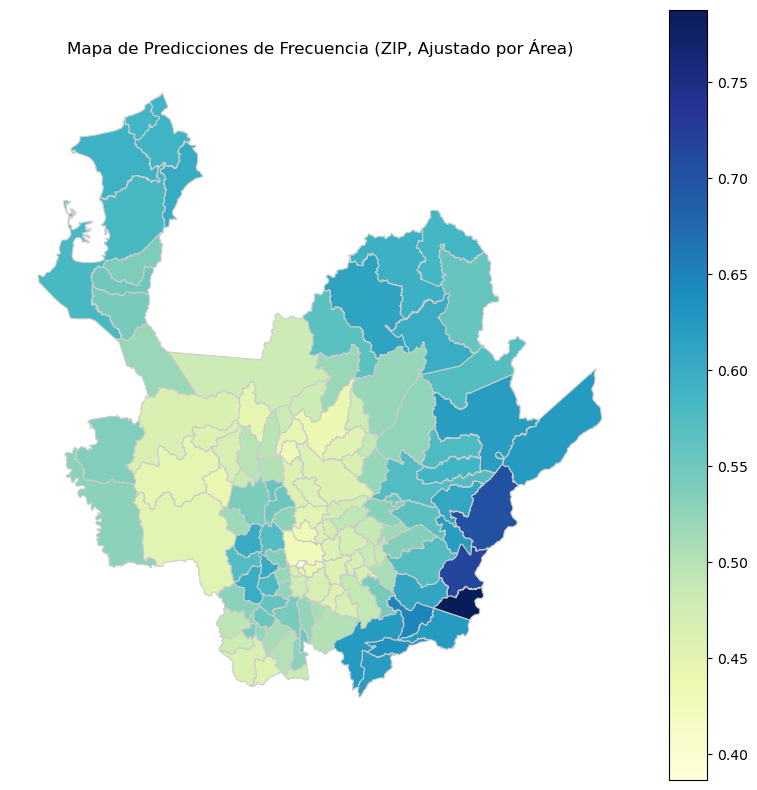

In [54]:
# Plotting the predictions for Zero-Inflated Poisson model with offset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="predicted_cfr_zip_offset",
    cmap="YlGnBu",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
)
ax.set_title("Mapa de Predicciones de Frecuencia (ZIP, Ajustado por Área)")
ax.set_axis_off()
plt.show()

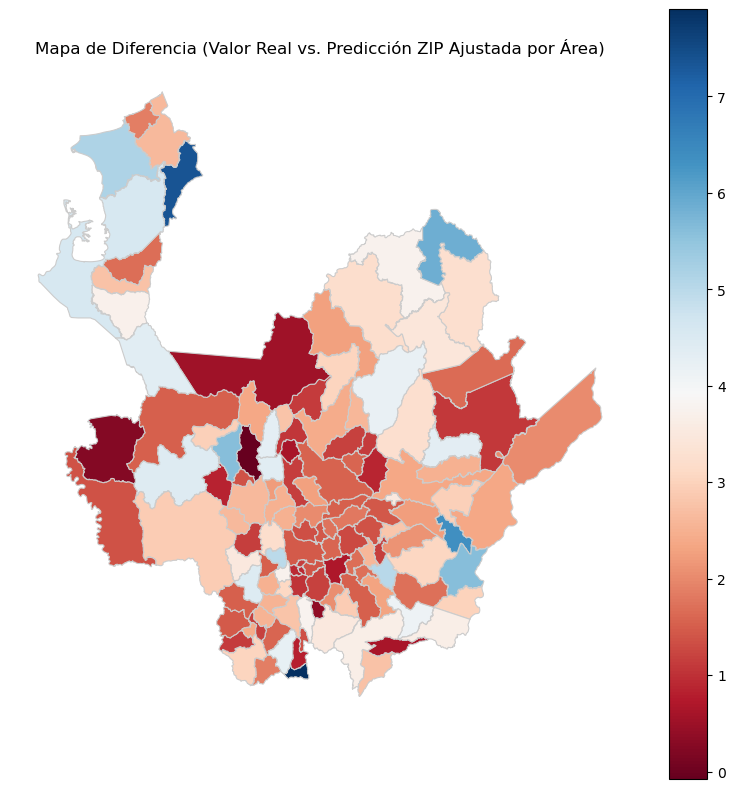

In [56]:
# Plotting the residuals for Zero-Inflated Poisson model with offset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="difference_cfr_zip_offset",
    cmap="RdBu",
    legend=True,
    ax=ax,
    linewidth=0.8,
    edgecolor="0.8",
)
ax.set_title("Mapa de Diferencia (Valor Real vs. Predicción ZIP Ajustada por Área)")
ax.set_axis_off()
plt.show()